# LAB 5. LSTM FOR TEXT CLASSIFICATION & SENTIMENT ANALYSIS

In [3]:
"""1. Load the pipeline and the en_core_web_md modules
2. Show the components considered in the pipeline
3. Load the SA dataset from Campus Virtual
4. Explore the dataset to describe it
5. Add the text categorizer component (using a multilabel model) to the pipeline
6. Add two labels: positive and negative sentiments
7. Create the comments’ samples
8. Initialize the pipeline
9. Enable the text categorizer component to be trained
10. Create an optimizer object (resume_training) to keep weights of existing statistical
models
11. Set 5 training epochs, and loss values
12. Test new data"""

'1. Load the pipeline and the en_core_web_md modules\n2. Show the components considered in the pipeline\n3. Load the SA dataset from Campus Virtual\n4. Explore the dataset to describe it\n5. Add the text categorizer component (using a multilabel model) to the pipeline\n6. Add two labels: positive and negative sentiments\n7. Create the comments’ samples\n8. Initialize the pipeline\n9. Enable the text categorizer component to be trained\n10. Create an optimizer object (resume_training) to keep weights of existing statistical\nmodels\n11. Set 5 training epochs, and loss values\n12. Test new data'

In [4]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


### 1. Load the pipeline and the en_core_web_md modules

In [1]:
#Load the pipeline and the en_core_web_md modules
import spacy

spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.7 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### 2. Show the components considered in the pipeline

In [6]:
#Show the components considered in the pipeline
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### 3. Load the SA dataset from Campus Virtual

In [7]:
#Load the SA dataset from Campus Virtual
import pandas as pd

sadataset = pd.read_csv("./contents/SA_dataset.csv")

In [8]:
sadataset.head()

,Review,Rating,Sentiment
0,**Possible Spoilers**,1,0
1,"Read the book, forget the movie!",2,0
2,**Possible Spoilers Ahead**,2,0
3,"What a script, what a story, what a mess!",2,0
4,I hope this group of film-makers never re-unites.,1,0


### 4. Explore the dataset to describe it

In [9]:
#Explore the dataset to describe it
print(sadataset.describe())


            Rating    Sentiment
count  5000.000000  5000.000000
mean      5.902200     0.550000
std       3.653944     0.497543
min       1.000000     0.000000
25%       2.000000     0.000000
50%       7.000000     1.000000
75%      10.000000     1.000000
max      10.000000     1.000000


In [10]:
#Get rating distribution
rating_distribution = sadataset['Rating'].value_counts()
print(rating_distribution)
#Now print it in percentages 
rating_distribution = sadataset['Rating'].value_counts(normalize=True)
print(rating_distribution)

Rating
10    1385
1     1061
8      520
9      472
3      401
4      401
2      387
7      373
Name: count, dtype: int64
Rating
10    0.2770
1     0.2122
8     0.1040
9     0.0944
3     0.0802
4     0.0802
2     0.0774
7     0.0746
Name: proportion, dtype: float64


### 5. Add the text categorizer component (using a multilabel model) to the pipeline

In [11]:
# Add the text categorizer component (using a multilabel model) to the pipeline
textcat= nlp.add_pipe("textcat")

print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'textcat']


### 6. Add two labels: positive and negative sentiments

In [12]:
#Add two labels: positive and negative sentiments
nlp.get_pipe("textcat").add_label("positive")
nlp.get_pipe("textcat").add_label("negative")


1

### 7. Create the comments’ samples

In [11]:
sadataset.tail()

,Review,Rating,Sentiment
4995,"I have only seen this once--in 1986, at an ""ar...",10,1
4996,"This being my first John Carpenter film, I mus...",9,1
4997,"This is kind of a weird movie, given that Sant...",1,0
4998,"Vic (Richard Dreyfuss) is a mob boss, leaving ...",4,0
4999,"Yup, that's right folks, this is undoubtedly t...",1,0


In [12]:
# Training the model
from sklearn.model_selection import train_test_split

X = sadataset['Review'].values
y = sadataset['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Training the model
from spacy.training import Example

def create_examples(X, y):
    examples = []
    for text, label in zip(X, y):
        examples.append(Example.from_dict(nlp.make_doc(text), {'cats': {'positive': int(label), 'negative': int(not label)}}))
    return examples

train_examples = create_examples(X_train, y_train)
test_examples = create_examples(X_test, y_test)

### 8. Initialize the pipeline

In [14]:
#Spacy's Example class is used to create the training data
from spacy.training.example import Example
inp = Example.from_dict(nlp.make_doc("This is a good product"), {"cats": {"positive": 1, "negative": 0}})
textcat.initialize(lambda: [inp], nlp = nlp)

### 9. Enable the text categorizer component to be trained

### 10. Create an optimizer object (resume_training) to keep weights of existing statistical models


#Create an optimizer object (resume_training) to keep weights of existing statistical models
from spacy.util import minibatch
import random
from sklearn.model_selection import train_test_split

random.seed(1)
spacy.util.fix_random_seed(1)

optimizer = nlp.resume_training()

In [ ]:
optimizer = nlp.resume_training()
losses = []

### 11. Set 5 training epochs, and loss values

In [17]:

optimizer = nlp.resume_training()
losses = []

dict_values([0.0, 0.0, 0.0, 0.0, 506.92547173344065])
Epoch 1/5: Loss 0.1267
[0.12673136793336015]
dict_values([0.0, 0.0, 0.0, 0.0, 387.16128335330495])
Epoch 2/5: Loss 0.0968
[0.12673136793336015, 0.09679032083832624]
dict_values([0.0, 0.0, 0.0, 0.0, 297.09046362149206])
Epoch 3/5: Loss 0.0743
[0.12673136793336015, 0.09679032083832624, 0.07427261590537301]
dict_values([0.0, 0.0, 0.0, 0.0, 249.6451781849222])
Epoch 4/5: Loss 0.0624
[0.12673136793336015, 0.09679032083832624, 0.07427261590537301, 0.06241129454623055]
dict_values([0.0, 0.0, 0.0, 0.0, 217.59198561411705])
Epoch 5/5: Loss 0.0544
[0.12673136793336015, 0.09679032083832624, 0.07427261590537301, 0.06241129454623055, 0.05439799640352926]


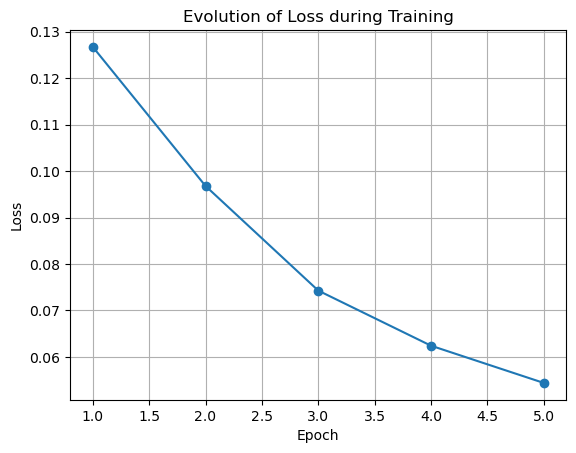

In [18]:
import matplotlib.pyplot as plt
import random
epochs = 5 
losses = []
for epoch in range(epochs):
    # Shuffle the training data
    random.shuffle(train_examples)
    # Iterate over batches
    batch_losses = {}
    for batch in spacy.util.minibatch(train_examples, size=2):
        # Update the model with examples
        nlp.update(batch, drop=0.5, losses=batch_losses, sgd=optimizer)
        
    print(batch_losses.values())
    epoch_loss = sum(batch_losses.values()) / len(train_examples)
    
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}: Loss {epoch_loss:.4f}")
    print(losses)
    
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss during Training')
plt.grid(True)
plt.show()

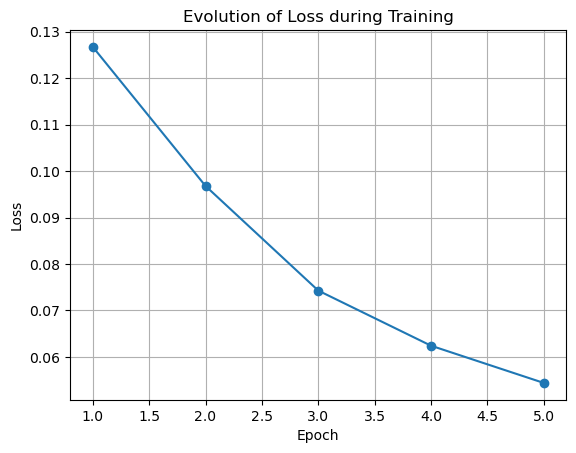

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss during Training')
plt.grid(True)
plt.show()

### 12. Test new data

In [20]:
#Test new data
test_text = "This movie sucked, you should not see it"

doc = nlp(test_text)
doc.cats



{'positive': 0.0021147613879293203, 'negative': 0.9978851675987244}

In [21]:
import numpy as np
test_text = "This movie was the best one I have ever seen, i loved it"

doc = nlp(test_text)
doc.cats

{'positive': 0.9997885823249817, 'negative': 0.00021148734958842397}

In [25]:
#Test with misleading data
test_text = "Even this movie won the oscars, you should NOT see it, it is horrendous"

doc = nlp(test_text)
doc.cats

{'positive': 0.9998021721839905, 'negative': 0.00019783512107096612}

In [26]:
#Test with misleading data
test_text = "Even this movie won the oscars, you should NOT see it, it is very bad"

doc = nlp(test_text)
doc.cats

{'positive': 0.0018819154938682914, 'negative': 0.9981181621551514}

## KERAS MODEL 

LSTM using Keras and Tensorflow

### 1- Use same dataset as previous analysis

In [2]:
import pandas as pd

Pytorch_dataset = pd.read_csv("./contents/SA_dataset.csv")

In [3]:
# Training the model
from sklearn.model_selection import train_test_split

X = Pytorch_dataset['Review'].values
y = Pytorch_dataset['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
import nltk
# Initialize NLTK sentence tokenizer
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Tokenize the large text into sentences
train_sentences = []
train_labels = []
for samp, label in zip(X_train, y_train):
    train_samp = sentence_tokenizer.tokenize(samp)
    train_sentences = train_sentences + train_samp
    new_lab = [label] * len(train_samp)
    train_labels = train_labels + new_lab
print("check that both labels and samples have the same length:",len(train_sentences), len(train_labels))
test_sentences = []
test_labels = []
for samp, label in zip(X_test, y_test):
    test_samp = sentence_tokenizer.tokenize(samp)
    test_sentences = test_sentences + sentence_tokenizer.tokenize(samp)
    new_lab = [label] * len(test_samp)
    test_labels = test_labels + new_lab
print("check that both labels and samples have the same length:",len(test_sentences), len(test_labels))    

check that both labels and samples have the same length: 17530 17530
check that both labels and samples have the same length: 4447 4447


In [5]:
import torchtext
import torch
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")
X_train_tokenized = [tokenizer(sentence) for sentence in train_sentences]
X_train_tokenized

tokenizer = get_tokenizer("basic_english")
X_test_tokenized = [tokenizer(sentence) for sentence in test_sentences]


In [6]:
sentence_set = set()
[[sentence_set.add(word) for word in sent] for sent in X_train_tokenized]
print("")

In [7]:
word_dict = {'<pad>':0,
        '<eos>':1,
        '<unk>':2}

#Create a dictionary with all the words in the vocabulary associated with a value
for i,word in enumerate(sentence_set):
    word_dict[word] = i+3
    

sentence_set.add('<eos>')
sentence_set.add('<unk>')
sentence_set.add('<pad>')

In [8]:
vocabulary_size = len(sentence_set)
vocabulary_size

17268

from transformers import AutoTokenizer, BertModel

import torch

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")



In [9]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
class LSTM_data(Dataset):
    def __init__(self, X, y,word_dict,transform=None):
        self.X = X
        self.y = y
        self.word_dict = word_dict
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        idx_seq = []
        padding = torch.zeros(50)
        if len(self.X[idx]) > 50:
            X_ret = self.X[idx][:50]
        else:
            X_ret = self.X[idx]
        #print(X_ret)
        #print(self.X)
        for word in X_ret:
            if word in self.word_dict.keys():
                idx_seq.append(self.word_dict[word])
            else:
                idx_seq.append(self.word_dict['<unk>'])
        
        idx_seq = torch.tensor(idx_seq)
        
        length = 50 - len(idx_seq) 
        if length != 0:
            padding = torch.zeros(length)
            padded_sequences = torch.cat((idx_seq, padding), dim = 0)
        #padded_sequences = pad_sequence((padding, idx_seq), batch_first=True, padding_value=0)
       # padded_sequences 
        else:
            padded_sequences = idx_seq
        
        
        y_ret = torch.tensor([self.y[idx]])
        
        return padded_sequences, y_ret

In [10]:
train_data = LSTM_data(X_train_tokenized, train_labels, word_dict)
test_data = LSTM_data(X_test_tokenized, test_labels, word_dict)

train_loader = DataLoader(train_data, batch_size=64,shuffle=True)
test_loader = DataLoader(test_data, batch_size=64,shuffle=True)

In [11]:
import torch
import torch.nn as nn

In [12]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
class simple_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(simple_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first = True, bidirectional = True)
        self.hidden2label = nn.Linear(hidden_dim*50*2, 1)
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, sentence):
        bs,_ = sentence.shape
        sentence = sentence.long()
        embeds = self.word_embeddings(sentence)
        embeds = self.relu(embeds)
        
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.relu(lstm_out)
        lstm_out = self.dropout(lstm_out)
        #print("out", lstm_out.shape)
        lstm_out = lstm_out.reshape(bs, -1)
        label_space = self.hidden2label(lstm_out)
        label_space = self.sigmoid(label_space)
        lstm_out = self.dropout(lstm_out)
        return label_space

In [63]:
torch

<module 'torch' from '/home/samper12/.conda/envs/pytorch12/lib/python3.11/site-packages/torch/__init__.py'>

In [64]:
from torch.nn import BCEWithLogitsLoss
embedding_dim = 100
hidden_dim = 256
vocab_size = vocabulary_size
target_size = 1 
model = simple_LSTM(embedding_dim, hidden_dim, vocab_size, target_size).to(device)

learning_rate = 0.005  # Set the learning rate for the optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Create an Adam optimizer and pass the model parameters to optimize

criterion = torch.nn.BCELoss()

In [65]:
import numpy as np
def compute_accuracy(tensor1, tensor2):
    """
    Compute accuracy between two tensors.
    
    Args:
    - tensor1: First tensor
    - tensor2: Second tensor
    
    Returns:
    - Accuracy: Percentage of matching elements between the two tensors
    """
    # Ensure tensors are of the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape for comparison.")
    
    
        
    # Convert tensors to numpy arrays for comparison
    
    array1 = np.array([round(num) for num in tensor1.cpu().detach().numpy()])
    array2 = tensor2.cpu().detach().numpy()

    # Count the number of matching elements
    num_matching = (array1 == array2).sum()

    # Compute accuracy

    accuracy = num_matching / tensor1.numel()
    #accuracies.append(accuracy)
    return accuracy

def validation(model, test_loader, epoch):
    for sent1, label1 in test_loader:
        sent1 = sent1.to(device)
        label1 = label1.to(device)
        label1 = label1.float()
        with torch.no_grad():
            
            preds = model(sent1)
            loss = criterion(preds,label1)
    preds = preds.squeeze()
    label1 = label1.squeeze()
    accuracy = compute_accuracy(preds, label1)
    
    
    
    #print('VALIDATION loss at epoch', epoch, "is:", loss.item())
    #print('ACCURACY:', accuracy, '\n')
    return accuracy

In [81]:
epochs = 5
losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    model.train()
    tot_loss = 0 
    
    for sent, label in train_loader:
        sent = sent.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        preds = model(sent)
        #preds = preds.squeeze()
        #label = label.squeeze()
        #print('preds', preds.dtype, label.dtype)

        label = label.float()
        #print(preds.shape, label.shape)

        
        loss = criterion(preds,label)
        
        loss.backward()
        
        optimizer.step()
        
        tot_loss += loss.item()
    
    print('TRAIN at epoch', epoch, 'is:', tot_loss, '\n')
    train_accuracy = validation(model, train_loader, epoch)
    print('TRAIN ACCURACY at epoch', epoch, 'is', train_accuracy)
    val_accuracy = validation(model, test_loader, epoch)
    print('VALIDATION ACCURACY at epoch', epoch, 'is', val_accuracy)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    losses.append(tot_loss)  
        

TRAIN at epoch 0 is: 50.87233643233776 

TRAIN ACCURACY at epoch 0 is 0.9137931034482759
VALIDATION ACCURACY at epoch 0 is 0.7741935483870968
TRAIN at epoch 1 is: 41.308483209460974 

TRAIN ACCURACY at epoch 1 is 0.9310344827586207
VALIDATION ACCURACY at epoch 1 is 0.7741935483870968
TRAIN at epoch 2 is: 32.95637100934982 

TRAIN ACCURACY at epoch 2 is 0.9310344827586207
VALIDATION ACCURACY at epoch 2 is 0.9032258064516129
TRAIN at epoch 3 is: 28.36411747150123 

TRAIN ACCURACY at epoch 3 is 0.9482758620689655
VALIDATION ACCURACY at epoch 3 is 0.7419354838709677
TRAIN at epoch 4 is: 25.25155226327479 

TRAIN ACCURACY at epoch 4 is 0.9827586206896551
VALIDATION ACCURACY at epoch 4 is 0.7741935483870968


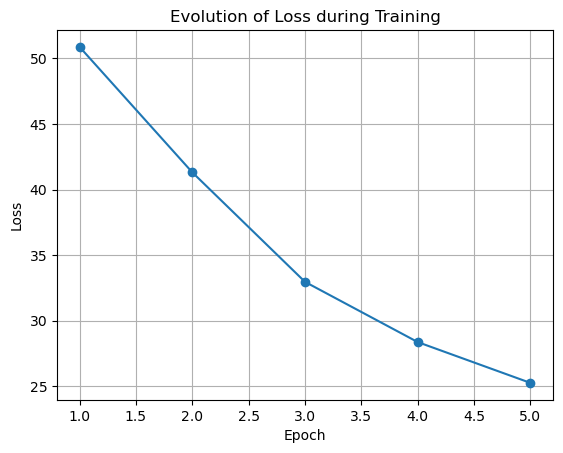

In [86]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Loss during Training')
plt.grid(True)
plt.show()

In [87]:
val_accuracies

[0.7741935483870968,
 0.7741935483870968,
 0.9032258064516129,
 0.7419354838709677,
 0.7741935483870968]

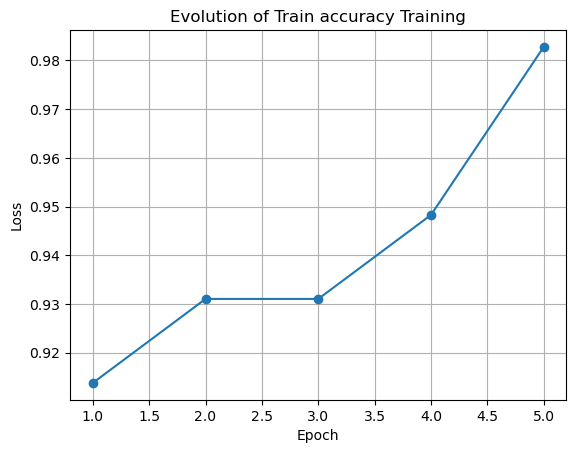

In [88]:
plt.plot(range(1, epochs + 1), train_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Train accuracy Training')
plt.grid(True)
plt.show()

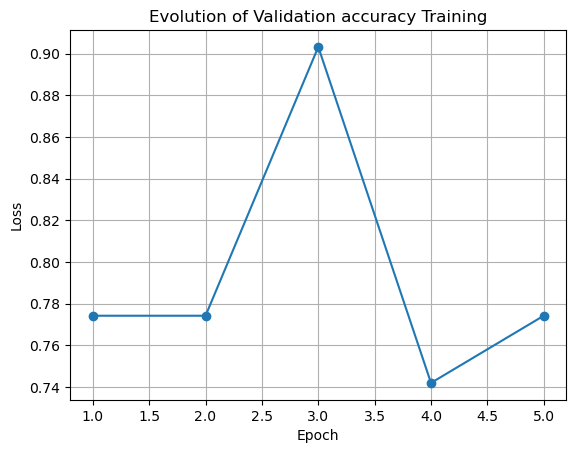

In [89]:
plt.plot(range(1, epochs + 1), val_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Validation accuracy Training')
plt.grid(True)
plt.show()

### 10- Train with new samples 

In [90]:
text = "This movie is horrendous, the worst I have seen."
idx_seq = []
#padding = torch.zeros(50)
padded_sequences = torch.tensor([])
for word in text:
    if word in word_dict.keys():
        idx_seq.append(word_dict[word])
    else:
        idx_seq.append(word_dict['<unk>'])

idx_seq = torch.tensor(idx_seq)

length = 50 - len(idx_seq) 
if length != 0:
    padding = torch.zeros(length)
    padded_sequences = torch.cat((idx_seq, padding), dim = 0)
#padded_sequences = pad_sequence((padding, idx_seq), batch_first=True, padding_value=0)
# padded_sequences 
else:
    padded_sequences = idx_seq

padded_sequences = padded_sequences.unsqueeze(0).to(device)

#y_ret = torch.tensor([self.y[idx]])



In [91]:
padded_sequences.shape

torch.Size([1, 50])

In [92]:
with torch.no_grad():
    pred = model.forward(padded_sequences)
print(pred[0][0])
torch.round(pred[0][0])

tensor(1.0000, device='cuda:0')


tensor(1., device='cuda:0')

In [93]:
text = "This movie is amaizng, you have to see it ."
idx_seq = []
#padding = torch.zeros(50)
padded_sequences = torch.tensor([])
for word in text:
    if word in word_dict.keys():
        idx_seq.append(word_dict[word])
    else:
        idx_seq.append(word_dict['<unk>'])

idx_seq = torch.tensor(idx_seq)

length = 50 - len(idx_seq) 
if length != 0:
    padding = torch.zeros(length)
    padded_sequences = torch.cat((idx_seq, padding), dim = 0)
#padded_sequences = pad_sequence((padding, idx_seq), batch_first=True, padding_value=0)
# padded_sequences 
else:
    padded_sequences = idx_seq

padded_sequences = padded_sequences.unsqueeze(0).to(device)

#y_ret = torch.tensor([self.y[idx]]

In [94]:
padded_sequences

tensor([[2.0000e+00, 1.0241e+04, 4.0580e+03, 5.5960e+03, 2.0000e+00, 1.1000e+02,
         4.3490e+03, 2.5050e+03, 4.0580e+03, 1.6978e+04, 2.0000e+00, 4.0580e+03,
         5.5960e+03, 2.0000e+00, 1.2428e+04, 1.1000e+02, 1.2428e+04, 4.0580e+03,
         1.3755e+04, 1.6154e+04, 4.5790e+03, 1.6038e+04, 2.0000e+00, 9.2000e+01,
         4.3490e+03, 1.1488e+04, 2.0000e+00, 1.0241e+04, 1.2428e+04, 2.5050e+03,
         1.6978e+04, 2.0000e+00, 6.6190e+03, 4.3490e+03, 2.0000e+00, 5.5960e+03,
         1.6978e+04, 1.6978e+04, 2.0000e+00, 4.0580e+03, 6.6190e+03, 2.0000e+00,
         1.2820e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]], device='cuda:0')

In [95]:
with torch.no_grad():
    pred = model.forward(padded_sequences)
print(pred[0][0].item())
torch.round(pred[0][0])

0.01219288632273674


tensor(0., device='cuda:0')